# Audio Processor
Convert audio file into metrics

- [Pitch](#pitch)
- Intensity
- Speech Tempo

In [115]:
import parselmouth
import numpy as np
import uuid
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

## Select audio file to analyze

In [116]:
audio_file_name = "/workspaces/voice-analysis/data/01_raw/tone-variety.wav"

## Pitch
Extracts frequency (Hz) of sound over a time series (seconds) 

##  Persist Pitch Metrics
In a new processed folder

In [117]:
# Process audio 
snd = parselmouth.Sound(audio_file_name)
# Extract Pitch timeseries
pitch = snd.to_pitch()
# Extract time & frequency to persist
dfPitch = pd.DataFrame(data=zip(pitch.xs(), pitch.selected_array['frequency']), columns=["time", "frequency"])

# Create new recording_id
new_guid = str(uuid.uuid4().hex)

# Destination Paths folder, processed wav and csv
base_name, extension = os.path.splitext(os.path.basename(audio_file_name))
destination_folder = f"/workspaces/voice-analysis/data/02_processed/{new_guid}__{base_name}{extension}/"
destination_wav = os.path.join(destination_folder, f"{new_guid}__{base_name}{extension}")
destination_csv = os.path.join(destination_folder, f"{new_guid}__{base_name}{extension}_pitch.csv")

# Create/ensure the folder
os.makedirs(destination_folder, exist_ok=True)

# Move the wav file to the new folder and rename it
shutil.copy(audio_file_name, destination_wav)

# Save data
dfPitch.to_csv(destination_csv, index=False)

## Plot Pitch Metrics

In [118]:
# Vocal Categories ranges 
categories = {
    'Soprano': {'range': [261.63, 1046.50], 'color': 'grey'},
    'Mezzo-Soprano': {'range': [220.00, 880.00], 'color': 'yellow'},
    'Alto': {'range': [174.61, 698.46], 'color': 'cyan'},
    'Tenor': {'range': [130.81, 523.25], 'color': 'green'},
    'Baritone': {'range': [98.00, 392.00], 'color': 'blue'},
    'Bass': {'range': [82.41, 329.63], 'color': 'red'}
}

def draw_horizontal_shadows(plt, transparency):    
    for  category_name, v in categories.items():
        plt.axhspan(v["range"][0], v["range"][1], facecolor = v["color"], alpha = transparency)            

def draw_legend(plt, transparency):    
    handle_values = []
    for  category_name, v in categories.items():        
        handle_values.append(mpatches.Patch(color=v["color"], alpha=transparency, label= f'{category_name}-{v["range"]}' ))
    plt.legend(handles= handle_values, loc='upper left', bbox_to_anchor=(1, 1))

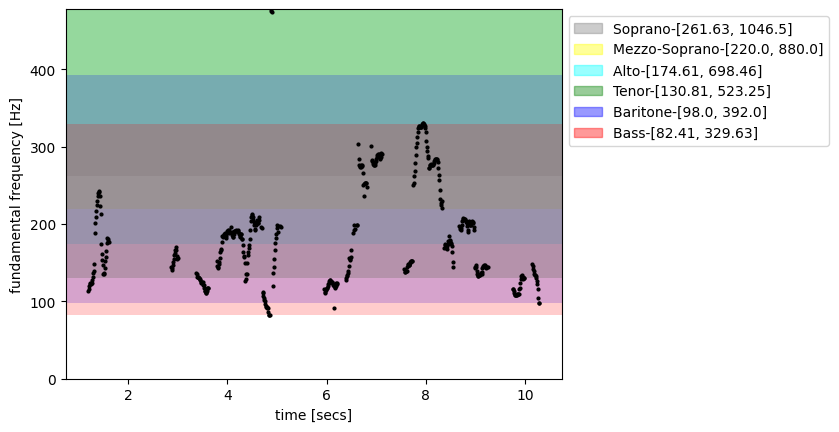

In [121]:
# replace unvoiced samples by NaN to not plot
pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values==0] = np.nan    
plt.plot(pitch.xs(), pitch_values, '.', markersize=4, color="black")            
plt.ylim(0, np.nanmax(pitch_values))  

plt.ylabel("fundamental frequency [Hz]")
plt.xlabel("time [secs]")

draw_horizontal_shadows(plt, 0.2)
draw_legend(plt, 0.4)

plt.show() 

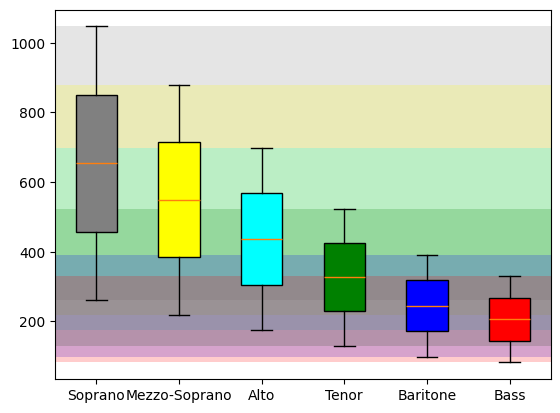

In [120]:

draw_horizontal_shadows(plt, 0.2)
#draw_legend(plt, 0.4)
box = plt.boxplot([v["range"] for v in categories.values()], patch_artist=True, tick_labels=categories.keys())
# Set the colors for each box
for patch, color in zip(box['boxes'], [v["color"] for v in categories.values()]):
    patch.set_facecolor(color)
    patch.set_alpha(1)

plt.show()